### Import dependencies

In [1]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import dolfin as dl


import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

TINY_SIZE = 10
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)    
plt.rc('xtick', labelsize=TINY_SIZE)    
plt.rc('ytick', labelsize=TINY_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=MEDIUM_SIZE)

np.random.seed(seed=1)

### Advection-diffusion problem

In [2]:
def AddDiffInverseProblem(nx, ny, v, gamma, plotting=False, isTV = False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess for inverted parameter
    mtrue = dl.interpolate(
            dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5),
                            Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f  = dl.Constant(1.0)
    u0 = dl.Constant(0.0)
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)
    
    # noise level
    noise_level = 0.01
    
    F = dl.inner(dl.grad(u), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u))*u_test*dl.dx \
            + mtrue*u**3*u_test*dl.dx - f*u_test*dl.dx

    # weak form for setting up the synthetic observations
    a_true = dl.inner(dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx \
            + mtrue*u_trial*u_test*dl.dx
    L_true = f * u_test * dl.dx
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)
    
    # solve the forward/state problem to generate synthetic observations
    dl.solve(F == 0, u, bc_state, solver_parameters={'newton_solver':
                                            {'relative_tolerance': 1e-6}})


    ud = dl.Function(Vu)
    ud.assign(u)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)
    ud.vector().axpy(1., noise)
    
    if plotting:
        plt.figure(figsize = (15,5))
        plt.subplot(121)
        dl.plot(u, title = "State solution with mtrue")
        plt.subplot(122)
        dl.plot(ud, title = "Synthetic observations")
        plt.show()
        
    # Define cost function
    def cost(u, ud, m, gamma):
        reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    F_state = dl.inner(dl.grad(u), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u))*u_test*dl.dx \
            + m*u**3*u_test*dl.dx - f*u_test*dl.dx  
    
    # weak form for setting up the adjoint equations
    a_adj = dl.inner( dl.grad(p_trial), dl.grad(p_test) ) * dl.dx \
            + dl.dot(v, dl.grad(p_test))*p_trial*dl.dx \
            + 3*m*u*u*p_trial*p_test*dl.dx
    L_adj = - dl.inner(u - ud, p_test) * dl.dx    
    
    # weak form for gradient
    CTvarf    = m_test*u**3*p * dl.dx
    gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    eps = dl.Constant(0.1)
    gradR_TV = dl.Constant(gamma)*(dl.inner(dl.grad(m), dl.grad(m)) + eps)**(-1/2) \
               * dl.inner(dl.grad(m), dl.grad(m_test)) * dl.dx
    
    # Mass matrix in parameter space
    Mvarf    = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(Mvarf)
    
    m0 = dl.interpolate(dl.Constant(4.), Vm )
    
    m.assign(m0)    
    
    # solve state equation
    dl.solve(F_state == 0, u, bc_state, solver_parameters={'newton_solver':
                                            {'relative_tolerance': 1e-6}})    
    
    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)
    
    if plotting:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        dl.plot(m,title="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
        plt.subplot(122)
        dl.plot(u, title="u(m0)")
        plt.show()
        
    tol = 1e-4
    maxiter = 1000
    c_armijo = 1e-5

    # initialize iter counters
    iter = 0
    converged = False
    
    # initializations
    g = dl.Vector()
    M.init_vector(g,0)
    
    m_prev = dl.Function(Vm)

    while iter <  maxiter and not converged:

        # solve the adoint problem
        adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        dl.solve(adj_A, p.vector(), adjoint_RHS)

        # evaluate the  gradient
        if isTV == True:
            MG = dl.assemble(CTvarf + gradR_TV)
        else:
            MG = dl.assemble(CTvarf + gradRvarf)
        dl.solve(M, g, MG)

        # calculate the norm of the gradient
        grad_norm2 = g.inner(MG)
        gradnorm = np.sqrt(grad_norm2)
    
        if iter == 0:
            gradnorm0 = gradnorm

        # linesearch
        it_backtrack = 0
        m_prev.assign(m)
        alpha = 1.e5
        backtrack_converged = False
        for it_backtrack in range(100):
        
            m.vector().axpy(-alpha, g )

            # solve the state/forward problem
#             F_state = dl.inner(dl.grad(u), dl.grad(u_test)) * dl.dx \
#                     + dl.dot(v, dl.grad(u))*u_test*dl.dx \
#                     + m*u**3*u_test*dl.dx - f*u_test*dl.dx  
            dl.solve(F_state == 0, u, bc_state, solver_parameters={'newton_solver':
                                            {'relative_tolerance': 1e-6}})    
            
            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old - alpha * c_armijo * grad_norm2:
                cost_old = cost_new
                backtrack_converged = True
                break
            else:
                alpha *= 0.5
                m.assign(m_prev)  # reset m
            
        if backtrack_converged == False:
            print( "Backtracking failed. A sufficient descent direction was not found" )
            converged = False
            break
    
        # check for convergence
        if gradnorm < tol*gradnorm0 and iter > 0:
            converged = True
            print ("Steepest descent converged in ",iter,"  iterations")
        
        iter += 1
    
    if not converged:
        print ( "Steepest descent did not converge in ", maxiter, " iterations")
        
    if plotting:
        plt.figure(figsize = (15,10))
        plt.subplot(221)
        dl.plot(mtrue, title = "mtrue")
        plt.subplot(222)
        dl.plot(m, title = "m")
        plt.subplot(223)
        dl.plot(u, title = "u")
        plt.subplot(224)
        dl.plot(p, title = "p")
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)
    return Vm.dim(), iter, noise_norm2, cost_new, misfit_new, reg_new    

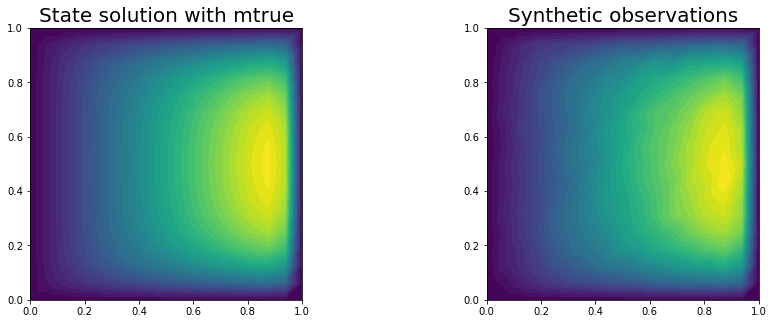

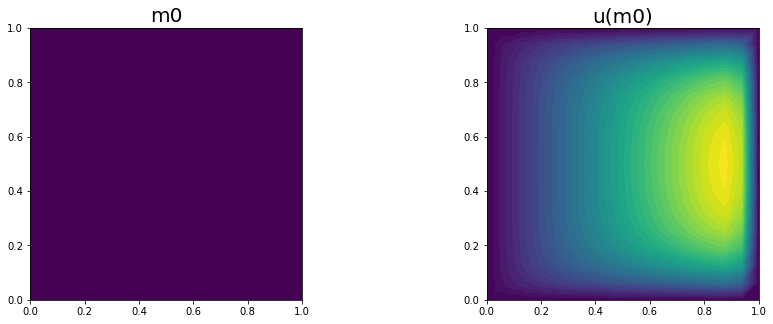

Backtracking failed. A sufficient descent direction was not found
Steepest descent did not converge in  1000  iterations


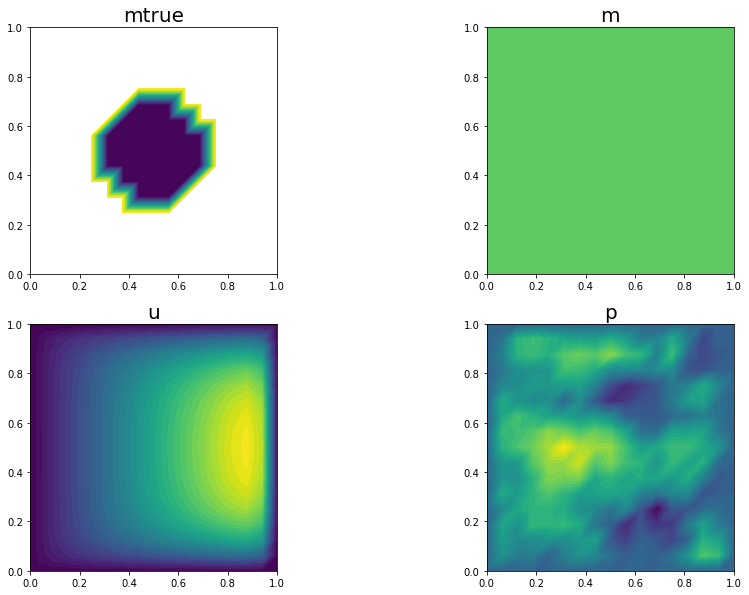

(289,
 0,
 4.477973592531814e-08,
 2.2387910581470214e-08,
 2.2387910581470214e-08,
 0.0)

In [3]:
n = 16
gamma = 5e-10
AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)),gamma = gamma, plotting=True, isTV = False)